# Ecological Public Good

> Class for ecological public good environment

The environment was introduced in 

> Barfuss, W., Donges, J. F., Vasconcelos, V. V., Kurths, J., & Levin, S. A. (2020). Caring for the future can turn tragedy into comedy for long-term collective action under risk of collapse. Proceedings of the National Academy of Sciences, 117(23), 12915-12922.

In [ ]:
#| default_exp Environments/EcologicalPublicGood

In [ ]:
#| hide
# Imports for the nbdev development environment
from nbdev.showdoc import *

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

## Example

In [ ]:
from MARLDynamics.Environments.EcologicalPublicGood import EcologicalPublicGood
from MARLDynamics.Agents.StrategyActorCritic import stratAC
from MARLDynamics.Utils import FlowPlot as fp
import numpy as np

In [ ]:
env = EcologicalPublicGood(N=2, f=1.2, c=5, m=-4, qc=0.2, qr=0.1, degraded_choice=True)
env

EcologicalPublicGood_2_1.2_5_-4_0.2_0.1_DegChoi

In the prosperous state, the rewards are a tragedy Prisoners' Dilemma.

In [ ]:
env.R[0,1,:,:,1], env.R[1,1,:,:,1]

(array([[ 1., -2.],
        [ 3.,  0.]]),
 array([[ 1.,  3.],
        [-2.,  0.]]))

Yet, because of the possible collapse and the agents' future outlook, the overall regime is one of coordination. 

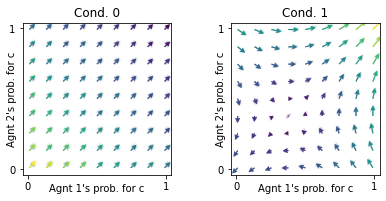

In [ ]:
# Init enviornment and MultiAgentEnvironment-interface
mae = stratAC(env=env, learning_rates=0.1, discount_factors=0.9)

x = ([0], [0,1], [0])  # Plotting only the prosperous state
y = ([1], [0,1], [0])  # Plotting only the prosperous state
ax = fp.plot_strategy_flow(mae, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)

## Implementation

In [ ]:
#| export
import numpy as np
from fastcore.utils import *
from fastcore.test import *

from typing import Iterable

from MARLDynamics.Environments.Base import ebase
from MARLDynamics.Utils.Helpers import make_variable_vector

In [ ]:
#| export
class EcologicalPublicGood(ebase):
    """
    Ecological Public Good Environment.
    """ 

    def __init__(self,
                 N:int,  # number of agents
                 f:Union[float, Iterable],  # public goods synergy factor
                 c:Union[float, Iterable],  # cost of cooperation
                 m:Union[float, Iterable], # collapse impact
                 qc:Union[float, Iterable], # collapse leverage/timescale
                 qr:Union[float, Iterable], # recovery leverage/timescale
                 degraded_choice=False):  # whether agents have a choice at the degraded state
        self.N = N
        self.M = 2
        self.Z = 2

        self.f = make_variable_vector(f, N)
        self.c = make_variable_vector(c, N)
        self.m = make_variable_vector(m, N)
        self.qc = make_variable_vector(qc, N)
        self.qr = make_variable_vector(qr, N)
        self.degraded_choice = degraded_choice
        
        self.Aset = self.actions()  # to have them available for the creation
        self.Sset = self.states()   # of the Transition and Reward Tensors

        self.state = 1 # inital state
        super().__init__()

In [ ]:
#| export
@patch
def actions(self:EcologicalPublicGood):
    """The action sets"""
    return [['c', 'd'] for _ in range(self.N)]

In [ ]:
#| export
@patch
def states(self:EcologicalPublicGood):
    """The states set"""
    return ['g', 'p'] 

In [ ]:
#| export
@patch
def TransitionTensor(self:EcologicalPublicGood):
    """Get the Transition Tensor."""
    dim = np.concatenate(([self.Z],
                          [self.M for _ in range(self.N)],
                          [self.Z]))
    Tsas = np.ones(dim) * (-1)

    for index, _ in np.ndenumerate(Tsas):
        Tsas[index] = self._transition_probability(index[0],
                                                   index[1:-1],
                                                   index[-1])
    return Tsas

@patch
def _transition_probability(self:EcologicalPublicGood,
                            s:int, # the state index
                            jA:Iterable, # indices for joint actions
                            s_:int  # the next-state index
                           ) -> float:  # transition probability 
    """
    Returns the transition probability for current state `s`, joint action `jA`, and next state `s_`.
    """
    transitionprob = 0

    if self.Sset[s] == 'p': # if we are in the prosperous state
        # determine the defectors
        defcs = np.where(np.array([act[jA[j]] for j, act
                                   in enumerate(self.Aset)]) == 'd')[0]            
        # and add up collapse leverages (= per actor collapse probabilites)
        transitionprob = np.sum([self.qc[i] for i in defcs]) /self.N

        if self.Sset[s_] == 'g': # if we collapsed
            return transitionprob  # that is our transition probability
        else:  # if we didn't collapse
            return 1-transitionprob  # it is the "inverse" proability

    else:  # if we are in the degraded state
        if self.degraded_choice:  # and if the agents' choice matter
            # determine cooperator
            coops = np.where(np.array([act[jA[j]] for j, act in enumerate(self.Aset)]) == 'c')[0]
            # and add up recovery leverages (= per actor recovery probabilites)
            transitionprob = np.sum([self.qr[i] for i in coops]) /self.N

        else:  # if the agents do not have a choice
            transitionprob = self.qr.mean()  # take the average collapse leverage

        if self.Sset[s_] == 'p':  # if we recovered
            return transitionprob  # that is our transition probability
        else:  # if we didnt' recovery
            return 1-transitionprob  # it is the "inverse" probability     


The `TransitionTensor` is obtained with the help of the `_transition_probability` method.

In [ ]:
show_doc(EcologicalPublicGood._transition_probability)

---

[source](https://github.com/wbarfuss/MARLDynamics/blob/main/MARLDynamics/Environments/EcologicalPublicGood.py#L75){target="_blank" style="float:right; font-size:smaller"}

### EcologicalPublicGood._transition_probability

>      EcologicalPublicGood._transition_probability (s:int, jA:Iterable, s_:int)

Returns the transition probability for current state `s`, joint action `jA`, and next state `s_`.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| s | int | the state index |
| jA | typing.Iterable | indices for joint actions |
| s_ | int | the next-state index |
| **Returns** | **float** | **transition probability** |

In [ ]:
#| export
@patch
def RewardTensor(self:EcologicalPublicGood):
    """Get the Reward Tensor R[i,s,a1,...,aN,s']."""
    dim = np.concatenate(([self.N],
                          [self.Z],
                          [self.M for _ in range(self.N)],
                          [self.Z]))
    Risas = np.zeros(dim)

    for index, _ in np.ndenumerate(Risas):
        Risas[index] = self._reward(index[0], index[1], index[2:-1],
                                    index[-1])
    return Risas

@patch
def _reward(self:EcologicalPublicGood,
            i:int, # the agent index
            s:int, # the state index
            jA:Iterable, # indices for joint actions
            s_:int  # the next-state index
            ) -> float:  # reward value
    """
    Returns the reward value for agent `i` in current state `s`, under joint action `jA`, when transitioning to next state `s_`.
    """
    if self.Sset[s] == 'g' or self.Sset[s_] == 'g':  # if either current or next state is degraded
        return self.m[i]  # the agents receive the collapse impact

    else:  # if current and next state are prosperous
        # determine cooperators
        coops = np.where(np.array([act[jA[j]] for j, act in enumerate(self.Aset)]) == 'c')[0]
        # and sum up reward contributions
        reward = np.sum([self.f[i] * self.c[i] for i in coops])/self.N 

        if self.Aset[i][jA[i]] == 'c':  # if focal player i is a cooperator
            reward -= self.c[i]  # subtract the cost of cooperation
        return reward

The `RewardTensor` is obtained with the help of the `_reward` method.

In [ ]:
show_doc(EcologicalPublicGood._reward)

---

[source](https://github.com/wbarfuss/MARLDynamics/blob/main/MARLDynamics/Environments/EcologicalPublicGood.py#L129){target="_blank" style="float:right; font-size:smaller"}

### EcologicalPublicGood._reward

>      EcologicalPublicGood._reward (i:int, s:int, jA:Iterable, s_:int)

Returns the reward value for agent `i` in current state `s`, under joint action `jA`, when transitioning to next state `s_`.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| i | int | the agent index |
| s | int | the state index |
| jA | typing.Iterable | indices for joint actions |
| s_ | int | the next-state index |
| **Returns** | **float** | **reward value** |

In [ ]:
#| export
@patch
def id(self:EcologicalPublicGood):
    """
    Returns id string of environment
    """
    # Default
    f = self.f if len(np.unique(self.f))>1 else self.f[0]
    c = self.c if len(np.unique(self.c))>1 else self.c[0]
    m = self.m if len(np.unique(self.m))>1 else self.m[0]
    qc = self.qc if len(np.unique(self.qc))>1 else self.qc[0]
    qr = self.qr if len(np.unique(self.qr))>1 else self.qr[0]

    id = f"{self.__class__.__name__}_"+\
        f"{self.N}_{str(f)}_{str(c)}_{str(m)}_{str(qc)}_{str(qr)}"
    if not self.degraded_choice:
        id += "_NoDegChoi"
    else:
        id += "_DegChoi"
    return id

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()